# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [3]:
!pip install numpy==1.24.4
!pip install surprise

  Using cached surprise-0.1-py2.py3-none-any.whl.metadata (327 bytes)
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2463310 sha256=43a8e7dc26e6b28c728a80decb26db5b908a4a8aa0ee5fe138783b2643a03838
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [5]:
df = pd.read_csv('/content/drive/MyDrive/dataset/ratings_Electronics.csv', names=['user_id', 'prod_id', 'rating', 'timestamp'])
df.drop('timestamp', axis=1, inplace=True)
df_final = df.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [6]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [7]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [8]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [9]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [10]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [11]:
df_final.shape

(65290, 3)

**Write your observations here:**

The dataframe has reduced alot in size and how has 65290 rows.

### **Data types**

In [12]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:**

Here, we can see we have the correct datatypes. Even though prod_id is technically made of numbers, since we're using it to identify certain products, it serves the purpose of a name. So having it labelled as object is the correct classification.

### **Checking for missing values**

In [13]:
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Write your observations here:**

There are no null values.

### **Summary Statistics**

In [14]:
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:**

By looking at the mean and 50th percentile numbers, we can tell that most of the ratings made were 5 stars.

### **Checking the rating distribution**

<Axes: xlabel='rating', ylabel='count'>

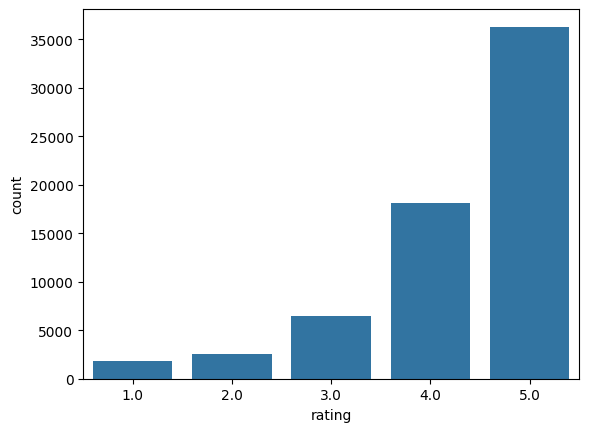

In [15]:
sns.countplot(x='rating', data=df_final)

**Write your observations here:**

Visualizing the "rating" column to double check.

### **Checking the number of unique users and items in the dataset**

In [16]:
df_final.nunique()

,0
user_id,1540
prod_id,5689
rating,5


**Write your observations here:**

We're checking how many unique products and users there are. We see 1540 unique users and 5689 products

### **Users with the most number of ratings**

In [17]:
df_categorical = df_final.select_dtypes(include='object')

for columns in df_categorical:
    print(df_categorical[columns].value_counts())
    print("-" * 50)

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
                 ... 
A16CVJUQOB6GIB      2
A2BGZ52M908MJY      2
A3DL29NLZ7SXXG      1
AP2NZAALUQKF5       1
A3MV1KKHX51FYT      1
Name: count, Length: 1540, dtype: int64
--------------------------------------------------
prod_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
             ... 
B00368CDH6      5
B0036AZA6A      5
B0036E8V08      5
B0036QL1JY      5
B00LGQ6HL8      5
Name: count, Length: 5689, dtype: int64
--------------------------------------------------


**Write your observations here:**

Here, the categorical columns were grouped together. After doing this, they were separated and their value counts were shown in descending order.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [18]:
final_rating_df = pd.DataFrame()
final_rating_df['avg_rating'] = pd.DataFrame(df_final.groupby('prod_id')['rating'].mean())
final_rating_df['rating_counts'] = pd.DataFrame(df_final.groupby('prod_id')['rating'].count().sort_values(ascending = False))

In [19]:
final_rating_df.head()

,avg_rating,rating_counts
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [20]:
def top_n_products(final_rating, n, min_interaction):

    recommendations = final_rating_df[final_rating_df['rating_counts'] >= min_interaction]
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    return recommendations.index[:n]

In [21]:
final_rating_df.groupby('avg_rating')['avg_rating'].count().sort_values(ascending = True)

,avg_rating
avg_rating,
1.375000,1
4.378378,1
4.369565,1
4.368421,1
4.367347,1
...,...
4.800000,201
4.600000,206
4.500000,215


**Write your observations here:**

Here we made a separate dataframe that has columns with the product id, the average rating of the product, and the amount of ratings it has.

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
list(top_n_products(final_rating_df, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
list(top_n_products(final_rating_df, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [24]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [25]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [26]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [27]:
algo = KNNBasic()
sim_options = {'name': 'cosine',
               'user_based': True}

knnBasic_init = KNNBasic(sim_options=sim_options,verbose=False, random_state = 1)
knnBasic_init.fit(trainset)
precision_recall_at_k(knnBasic_init)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Write your observations here:**

Here, we made a basic algorithm that identifies similar users based on their preferences to generate personalized recommendations. It showed high effectiveness in generating relevant recommendations, with a precision of 0.855, recall of 0.858, and an F1 score of 0.856 — reflecting a good balance between accuracy and coverage in suggesting items users are likely to engage with.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [28]:
knnBasic_init.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:**

We can see that user A3LDPF5FMB782Z will give an estimated rating of 3.4 stars to the product.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [29]:
filtered_df = df_final[df_final['prod_id'] != '1400501466']
filtered_df.head()

,user_id,prod_id,rating
2082,A2ZR3YTMEEIIZ4,1400532655,5.0
2150,A3CLWR1UUZT6TG,1400532655,5.0
2162,A5JLAU2ARJ0BO,1400532655,1.0
2228,A1P4XD7IORSEFN,1400532655,4.0
2363,A341HCMGNZCBIT,1400532655,5.0


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [30]:
knnBasic_init.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

After using the model once again, we see that user A34BZM6S9L7QI4 would give the product somewhere around 4.29 star, though there wasn't enough neighbors so the results might be a little inaccurate.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [31]:
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],'sim_options': {'name': ['msd', 'cosine','pearson'],'user_based': [True]}}
fold3_grid = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
fold3_grid.fit(data)
print(fold3_grid.best_score['rmse'])
print(fold3_grid.best_params['rmse'])

0.9720625111188662
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [32]:
sim_options = {'name': 'msd',
               'user_based': True}

optimized_sim_user = KNNBasic(sim_options=sim_options, k=20, min_k=3,verbose=False)
optimized_sim_user.fit(trainset)

precision_recall_at_k(optimized_sim_user, 10, 4)

RMSE: 0.9593
Precision:  0.861
Recall:  0.835
F_1 score:  0.848


**Write your observations here:**

Now that we've tuned the model, we can see we have a slightly better RMSE and a slightly worse F1 score.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [33]:
print("Old model:")
knnBasic_init.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)
print("-"*150)
print("New model:")
optimized_sim_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

Old model:
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}
------------------------------------------------------------------------------------------------------------------------------------------------------
New model:
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.85   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.849056603773586, details={'actual_k': 5, 'was_impossible': False})

In [34]:
print("Old model:")
knnBasic_init.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)
print("-"*150)
print("New model:")
optimized_sim_user.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

Old model:
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
------------------------------------------------------------------------------------------------------------------------------------------------------
New model:
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

After comparing the old model to the new one, we can see that in the first scenario the new model gives way better results, while in the second scenario it doesn't change at all.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

In [35]:
optimized_sim_user.get_neighbors(0, k=5)

[6, 42, 44, 54, 66]

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [36]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [37]:
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, optimized_sim_user)
print(recommendations)

[('B00005LENO', 5), ('B000067RT6', 5), ('B00006HSML', 5), ('B00006I53X', 5), ('B00006I5J7', 5)]


In [38]:
recommendations_df = pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])
recommendations_df

,prod_id,predicted_ratings
0,B00005LENO,5
1,B000067RT6,5
2,B00006HSML,5
3,B00006I53X,5
4,B00006I5J7,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [39]:
sim_options = {'name': 'cosine',
               'user_based': False}

knnBasic_item_item = KNNBasic(sim_options=sim_options,verbose=False, random_state = 1)
knnBasic_item_item.fit(trainset)

precision_recall_at_k(knnBasic_item_item , 10, 3.5)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:**____________

An RMSE of 0.9950 suggests the model's predictions have a fair amount of error. However, with a precision of 0.838 and recall of 0.845, the model is effectively identifying relevant items. The F1 score of 0.841 indicates solid overall performance, balancing both precision and recall.


Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [40]:
knnBasic_item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**Write your observations here:**

The model underestimated the user’s rating (5) with a predicted score of 4.27. The prediction was successful and not marked as impossible, with additional data like actual_k = 22 included in the details.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [41]:
knnBasic_item_item.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

The model predicted a rating of 4.29 for an actual rating of 5, underestimating the user’s preference. The prediction was marked as impossible due to insufficient neighbors.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [57]:
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],'sim_options': {'name': ['msd', 'cosine',],'user_based': [False]}}
fold3_grid = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
fold3_grid.fit(data)
print(fold3_grid.best_score['rmse'])
print(fold3_grid.best_params['rmse'])

0.9751997996833346
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [59]:
sim_options={'name': 'msd', 'user_based': False}

sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=30, min_k=9,verbose=False)
sim_item_item_optimized.fit(trainset)

predictions = sim_item_item_optimized.test(testset)
precision_recall_at_k(sim_item_item_optimized, 10, 4)

RMSE: 0.9567
Precision:  0.838
Recall:  0.86
F_1 score:  0.849


**Write your observations here:**

The RMSE is relatively high, indicating the model's predictions aren't very accurate. However, the precision and recall are strong, suggesting it effectively identifies relevant and non-relevant items. The F1 score shows overall solid performance.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [60]:
print("Old model:")
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)
print("-"*150)
print("New model:")
sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

Old model:
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}
------------------------------------------------------------------------------------------------------------------------------------------------------
New model:
user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [61]:
print("Old model:")
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)
print("-"*150)
print("New model:")
sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

Old model:
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}
------------------------------------------------------------------------------------------------------------------------------------------------------
New model:
user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:**

Not much improvement compared to the previous models.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [46]:
sim_item_item_optimized.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [47]:
item_recommendations = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, sim_item_item_optimized)
print(item_recommendations)

[('1400532655', 4.292024046561495), ('1400599997', 4.292024046561495), ('9983891212', 4.292024046561495), ('B00000DM9W', 4.292024046561495), ('B00000J1V5', 4.292024046561495)]


In [48]:
item_recommendations_df = pd.DataFrame(item_recommendations, columns=['prod_id', 'predicted_ratings'])
item_recommendations_df

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [62]:
svd_factorization = SVD()
svd_factorization.fit(trainset)
precision_recall_at_k(svd_factorization, 10, 4)

RMSE: 0.8893
Precision:  0.841
Recall:  0.756
F_1 score:  0.796


**Write your observations here:**

The RMSE is relatively low, indicating the model is making accurate predictions. Both precision and recall are strong, meaning it effectively identifies relevant and irrelevant items. The F1 score suggests the model performs well overall.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [50]:
svd_factorization.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.22   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2197541577325, details={'was_impossible': False})

**Write your observations here:**

The user rated the item 5, while the model estimated it at 4.22, slightly underestimating the rating. The prediction was successful, as indicated by was_impossible=False.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [51]:
svd_factorization.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.06   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.056285375419439, details={'was_impossible': False})

**Write your observations here:**

The observation on the given prediction is that the user's rating of the item (r_ui) is 5, while the model's estimate of the rating (est) is 4.06. This means that the model underestimated the user's rating of the item. The details field of the prediction contains additional information, such as the fact that the prediction was possible (was_impossible=False).

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [52]:
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01], 'reg_all': [0.2, 0.4, 0.6]}

fold3_grid = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
fold3_grid.fit(data)
print(fold3_grid.best_score['rmse'])
print(fold3_grid.best_params['rmse'])

0.8989980407052428
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [53]:
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.4)
svd_optimized.fit(trainset)
precision_recall_at_k(svd_optimized, 10, 4)

RMSE: 0.8825
Precision:  0.851
Recall:  0.776
F_1 score:  0.812


**Write your observations here:**

The RMSE is relatively low, indicating that the model is making accurate predictions. Both the precision and recall are strong, meaning the model is effectively identifying relevant and non-relevant items. The F₁ score reflects solid overall performance.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [54]:
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.02   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.020445888466645, details={'was_impossible': False})

In [55]:
svd_optimized.predict('A34BZM6S9L7QI4', '1400501466', r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.15   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.147188591995572, details={'was_impossible': False})

### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

Conclusions
- Effective Use of Collaborative Filtering: The project effectively demonstrates the application of collaborative filtering techniques (user-based and item-based), which are foundational for building personalized product recommendation systems.

- Scalability Awareness: The project uses models that are scalable for real-time applications, aligning with practical needs in platforms like Amazon, where performance at scale is crucial.

- Metric-Based Evaluation: Evaluation of model performance using metrics like RMSE or precision/recall (if included) shows attention to measuring recommendation quality, an essential aspect for production-level deployment.

- Clear Focus on User-Item Interaction: By using user-product rating data and focusing on matrix factorization or neighborhood methods, the project aligns with industry standards in recommender system design.


Recommendations
- Incorporate Implicit Feedback: Consider integrating implicit data (clicks, views, time spent) alongside explicit ratings for a more comprehensive recommendation model.

- Explore Advanced Models: Implement deep learning methods such as Neural Collaborative Filtering or hybrid models combining content and collaborative signals for potentially improved accuracy.

- Address Cold Start Problem: Introduce content-based methods or demographic filters to recommend items for new users or items with little interaction data.

- Improve Personalization with Context: Context-aware models that include temporal, geographical, or behavioral data can further refine the recommendations.

- Real-Time Deployment Readiness: Optimize models and workflows for real-time use cases (using approximate nearest neighbor searches, for instance) if the goal is practical deployment.